# CS 4452 Assignment 1

## Problem 1: Image Detection

In [6]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt

### Q1. Smoothing Image 1 

using a 5×5 Gaussian filter with σ = 1 and σ = 2 (Implement the convolution process). Plot both smoothed images.

##### 1a. Loading Image 1

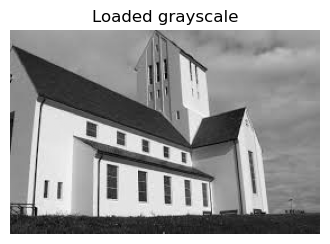

In [7]:
# Load image
image = plt.imread('image1.png')

if image.ndim == 2:
    grayscale = image
else:
    # RGB or RGBA -> drop alpha if present, then average channels
    grayscale = image[..., :3].mean(axis=2)

# normalize depending on dtype/range
grayscale = grayscale.astype(np.float32)
float_image = grayscale / (255.0 if grayscale.max() > 1.0 else 1.0)

plt.figure(figsize=(4,4))
plt.imshow(float_image, cmap="gray")
plt.axis("off")
plt.title("Loaded grayscale")
plt.show()

##### 1b. Building 5x5 Gaussian Kernel


In [8]:
def gaussian_kernel(size=5, sigma=1.0):
    """Create a size x size Gaussian kernel"""
    # Create a coordinate grid centered at 0
    ax = np.arange(-size // 2 + 1, size // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    
    # Calculate Gaussian values
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    
    # Normalize so sum equals 1
    return kernel / np.sum(kernel)

# Create 5x5 Gaussian kernel
kernel = gaussian_kernel(5, sigma=1.0)
print(kernel)

[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


##### 1c. Implement 2D Convolution Manually


In [9]:
def convolve2d_manual(img, kernel, padding="reflect"):
    img = np.asarray(img, dtype=np.float32)
    kernel = np.asarray(kernel, dtype=np.float32)

    kh, kw = kernel.shape
    assert kh % 2 == 1 and kw % 2 == 1, "Kernel must have odd dimensions (e.g., 5x5)"
    pad_h, pad_w = kh // 2, kw // 2

    # Flip kernel for convolution
    k = np.flipud(np.fliplr(kernel))

    pad_mode = {"reflect": "reflect", "edge": "edge", "constant": "constant"}[padding]
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode=pad_mode)

    H, W = img.shape
    out = np.zeros((H, W), dtype=np.float32)

    for i in range(H):
        for j in range(W):
            region = padded[i:i+kh, j:j+kw]
            out[i, j] = np.sum(region * k)

    return out

##### 1.d Plot Results

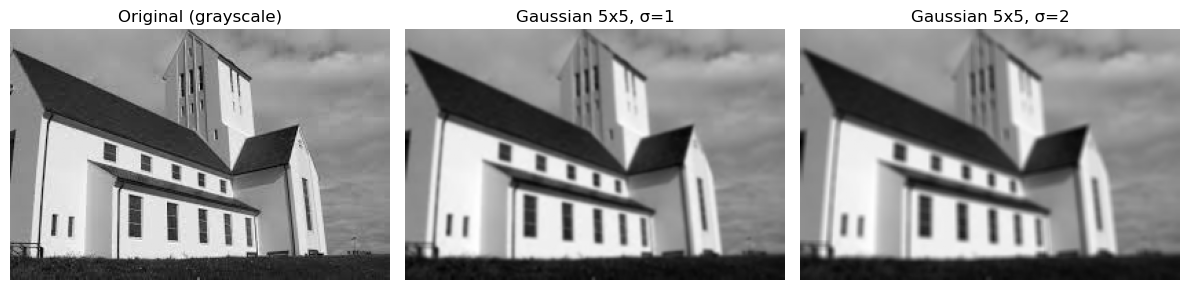

In [10]:
# Gaussian smoothing with sigma=1 and sigma=2
k1 = gaussian_kernel(5, sigma=1.0)
k2 = gaussian_kernel(5, sigma=2.0)

smooth_sigma1 = convolve2d_manual(float_image, k1, padding="reflect")
smooth_sigma2 = convolve2d_manual(float_image, k2, padding="reflect")

# Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original (grayscale)")
plt.imshow(float_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Gaussian 5x5, σ=1")
plt.imshow(smooth_sigma1, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Gaussian 5x5, σ=2")
plt.imshow(smooth_sigma2, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

### Q2. Apply Filters & Plotting 

implementing 3×3 Sobel filters 𝑆𝑥and 𝑆𝑦to each smoothed image from (a). Plot the
resulting 𝐺𝑥and 𝐺𝑦images (and optionally the gradient magnitude).

### Q3. Convolving Image 1 

using derivative-of-Gaussian filters ∂𝐺/ ∂𝑥 and ∂𝐺/ ∂𝑦, using
5×5 filters for σ = 1 and σ = 2. Plot the resulting 𝐺𝑥and 𝐺𝑦images for each σ

#### 4. Comparision 

the results of (b) and (c). Describing what is observed and why.

## Problem 2: Corner Detection

#### 1. Harris Corner Detector 

Implementing step-by-step and applying it to Image 1 and provide:

 - the corner response map 𝑅, and

 - the output after non-maximum suppression (final detected corners, ideally
overlaid on the image). 